## 1. Importing Libraries & Load the file

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
#from keras.utils import np_utils
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [4]:
# Reading Dataset
data = pd.read_csv('D:\Guvi\FinalImageProj\yfer2013.csv')
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [5]:
# Checking Shape of data
data.shape

(35887, 3)

## 2. Data Visualization

In [6]:
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
emotion_labels

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

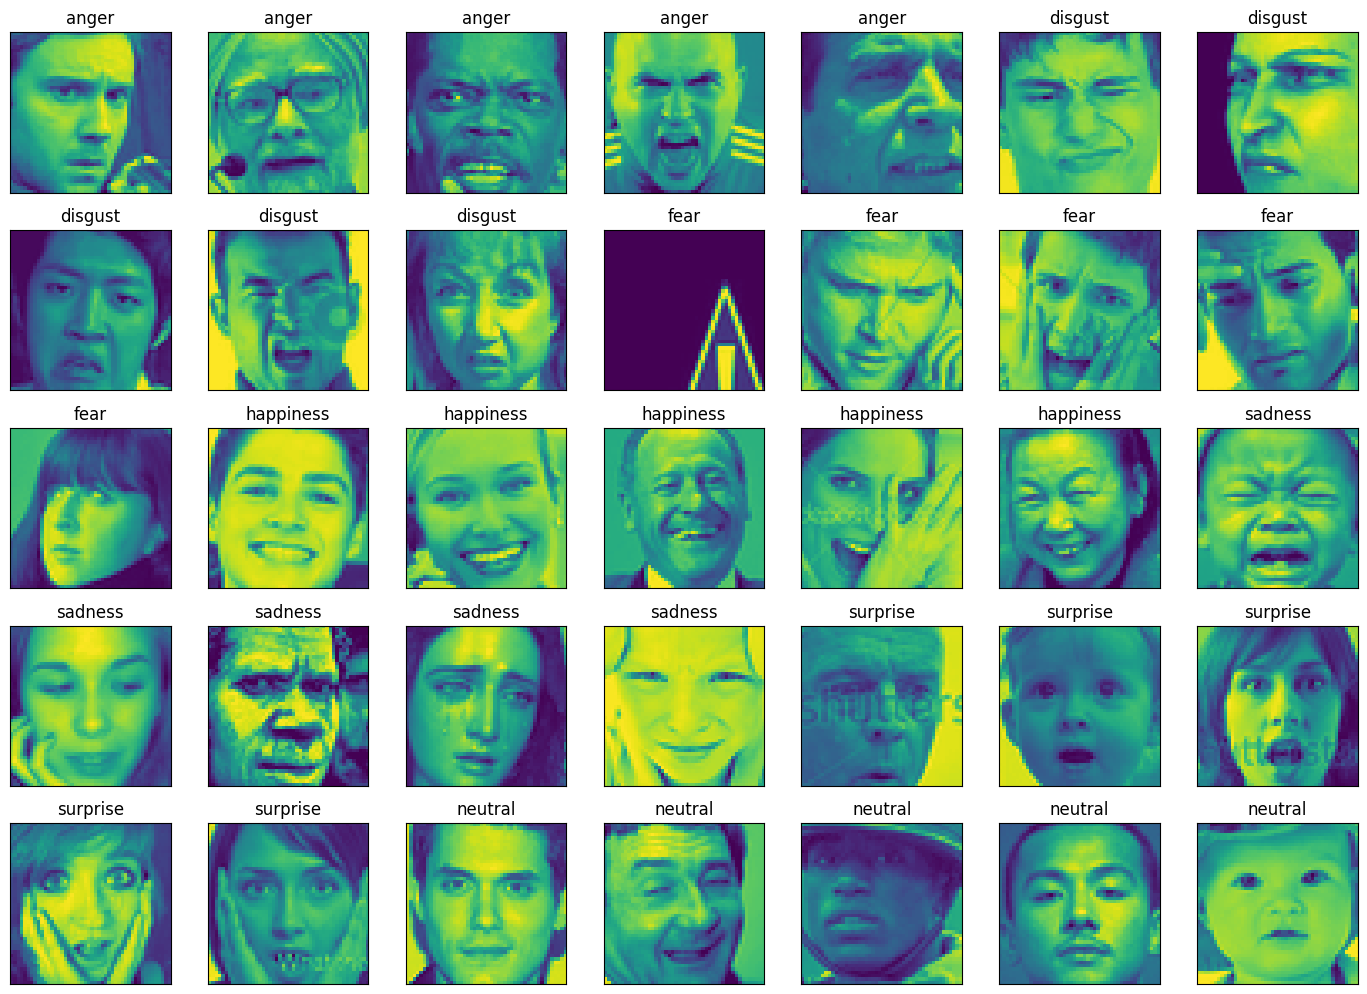

In [5]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_labels[label])
        plt.tight_layout()

In [7]:
# Checking Emotion Class Distribution
data['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

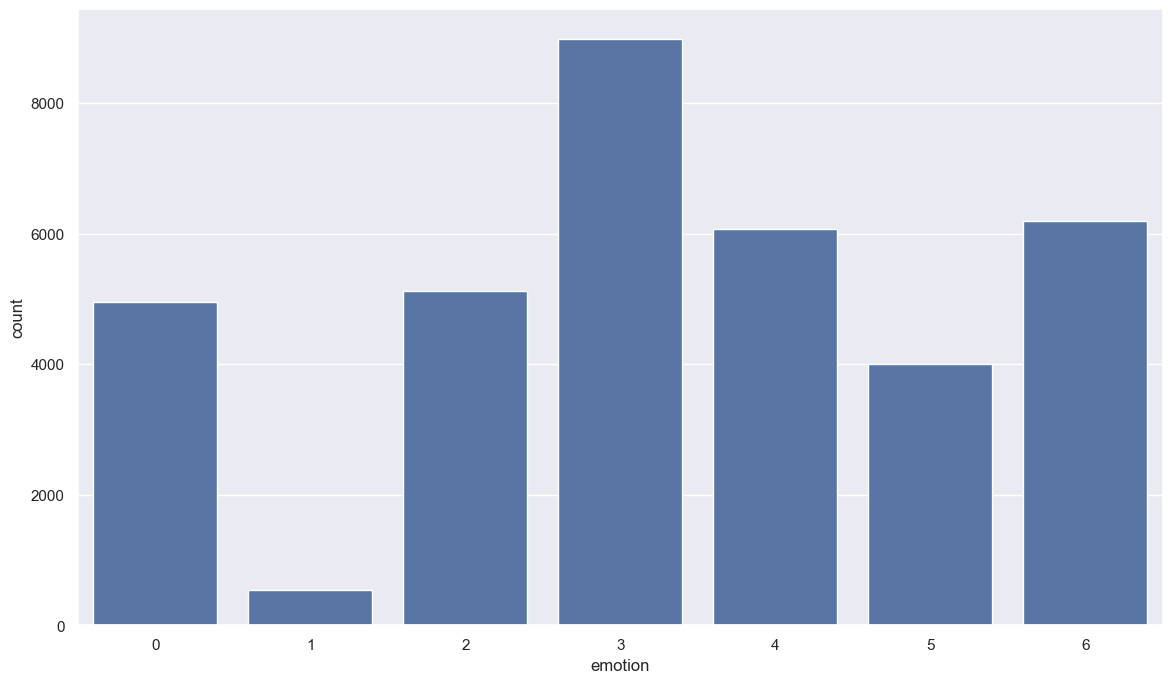

In [8]:
# Plotting the above distribution
plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

*The emotion chart above pictures that the emotions data is imbalanced. For some emotions there are very small number of images, Thus, we  need to balance data by oversampling technique so as to get enough number of images for every emotion.*

## 3. Data Pre-processing (Balancing & Preparation)

In [9]:
# Split the data into feature & target
x_data = data['pixels']
y_data = data['emotion']

In [10]:
# Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [11]:
# Let's check the distributio of target data again after balancing
y_data.value_counts().sort_values(ascending=False)

emotion
0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: count, dtype: int64

In [12]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    61 56 59 52 42 54 74 84 94 95 98 98 100 109 12...
62919    137 151 158 163 169 177 187 182 129 91 104 112...
62920    113 115 99 90 73 57 88 148 156 160 143 122 109...
62921    10 12 14 16 15 11 9 9 7 8 17 69 146 181 190 18...
62922    69 25 32 31 40 48 54 71 80 83 82 93 102 96 95 ...
Length: 62923, dtype: object

In [13]:
# Data Normalizng
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [14]:
# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [15]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [16]:
# Split the data and create train-test set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [17]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [18]:
# Perform One-Hot Encoding on training data
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [19]:
# Perform One-Hot Encoding on test data
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

## 4. Model Building

In [20]:
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(250, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation = 'softmax')
])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 128)           │              

 Total params: 792,855 (3.02 MB)

 Trainable params: 792,023 (3.02 MB)

 Non-trainable params: 832 (3.25 KB)

## 5. Model Training

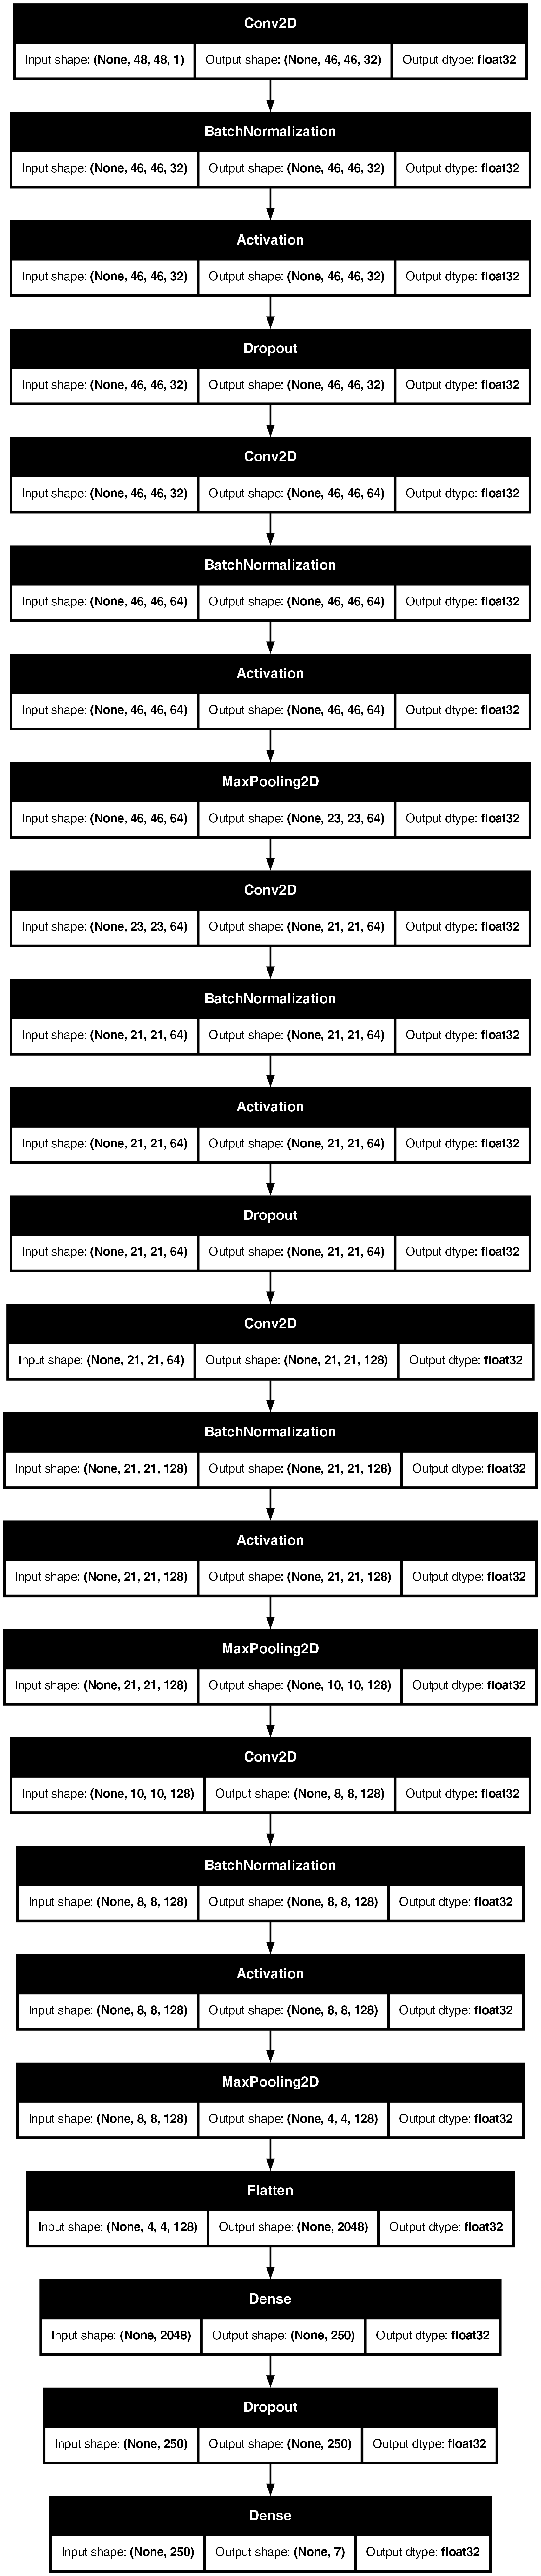

In [26]:
# Model Flowchart
tf.keras.utils.plot_model(model, to_file = "Model_flow.png", show_shapes = True, show_dtype = True)

In [22]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Train the Model
history = model.fit(x_train, y_train, epochs = 35, validation_data=(x_test, y_test))

Epoch 1/35
1770/1770 [==============================] - 45s 17ms/step - loss: 1.8193 - accuracy: 0.2754 - val_loss: 1.7512 - val_accuracy: 0.3261
Epoch 2/35
1770/1770 [==============================] - 31s 17ms/step - loss: 1.5353 - accuracy: 0.4115 - val_loss: 1.4483 - val_accuracy: 0.4602
Epoch 3/35
1770/1770 [==============================] - 31s 17ms/step - loss: 1.3744 - accuracy: 0.4779 - val_loss: 1.2652 - val_accuracy: 0.5152
Epoch 4/35
1770/1770 [==============================] - 31s 17ms/step - loss: 1.2593 - accuracy: 0.5227 - val_loss: 1.1853 - val_accuracy: 0.5443
Epoch 5/35
1770/1770 [==============================] - 31s 18ms/step - loss: 1.1733 - accuracy: 0.5566 - val_loss: 1.1039 - val_accuracy: 0.5710
Epoch 6/35
1770/1770 [==============================] - 31s 17ms/step - loss: 1.1032 - accuracy: 0.5830 - val_loss: 1.0158 - val_accuracy: 0.6105
Epoch 7/35
1770/1770 [==============================] - 31s 17ms/step - loss: 1.0455 - accuracy: 0.6052 - val_loss: 1.0199 -

## 6. Model Evaluation

In [25]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

197/197 [==============================] - 1s 5ms/step - loss: 0.6056 - accuracy: 0.8131
Accuracy of our model on test data :  81.31256699562073 %
197/197 [==============================] - 1s 5ms/step - loss: 0.6056 - accuracy: 0.8131
Loss of our model on test data :  0.6056268811225891


***The test accuracy & loss of our model is 81.31% & 0.605 respectively, which is better than many exsited state-of-the-art results.***

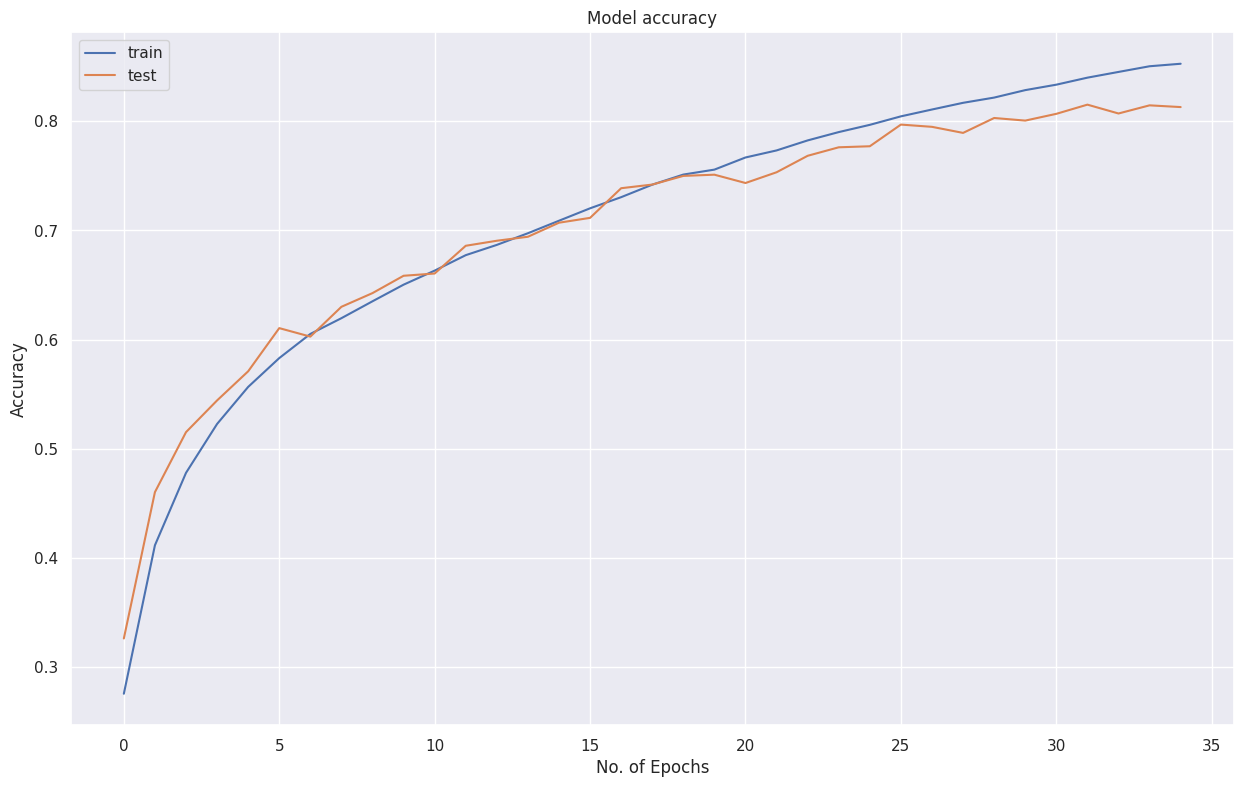

In [26]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

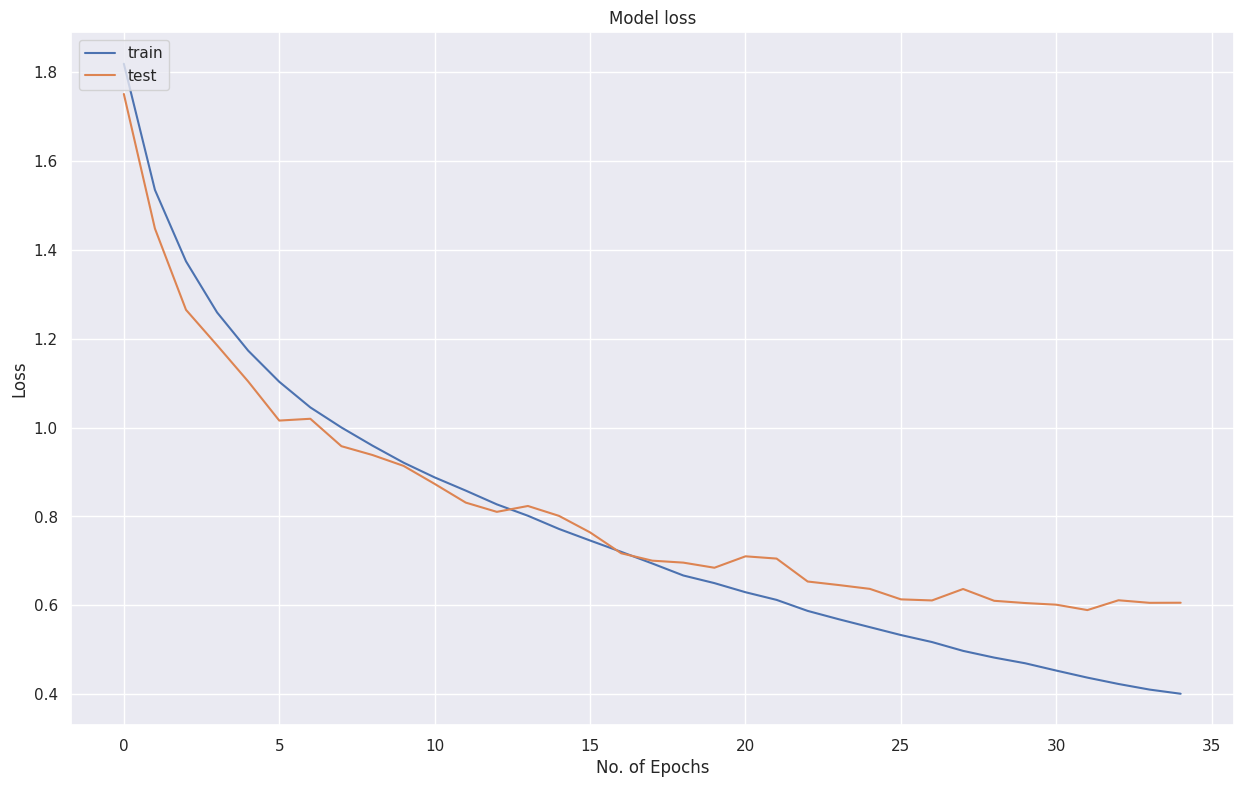

In [27]:
plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 7. Getting Classification Report & Plotting Confusion Matrix

In [28]:
# Making Predictio on Test Data
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 [==============================] - 1s 4ms/step


[6, 5, 5, 6, 1, 0, 6, 4, 1, 6]

In [29]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [30]:
# Getting Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.86      0.76      0.80       935
           1       0.99      1.00      0.99       895
           2       0.83      0.67      0.74       880
           3       0.86      0.80      0.83       906
           4       0.68      0.69      0.69       888
           5       0.87      0.96      0.91       869
           6       0.65      0.82      0.72       920

    accuracy                           0.81      6293
   macro avg       0.82      0.81      0.81      6293
weighted avg       0.82      0.81      0.81      6293



Text(178.75, 0.5, 'Truth')

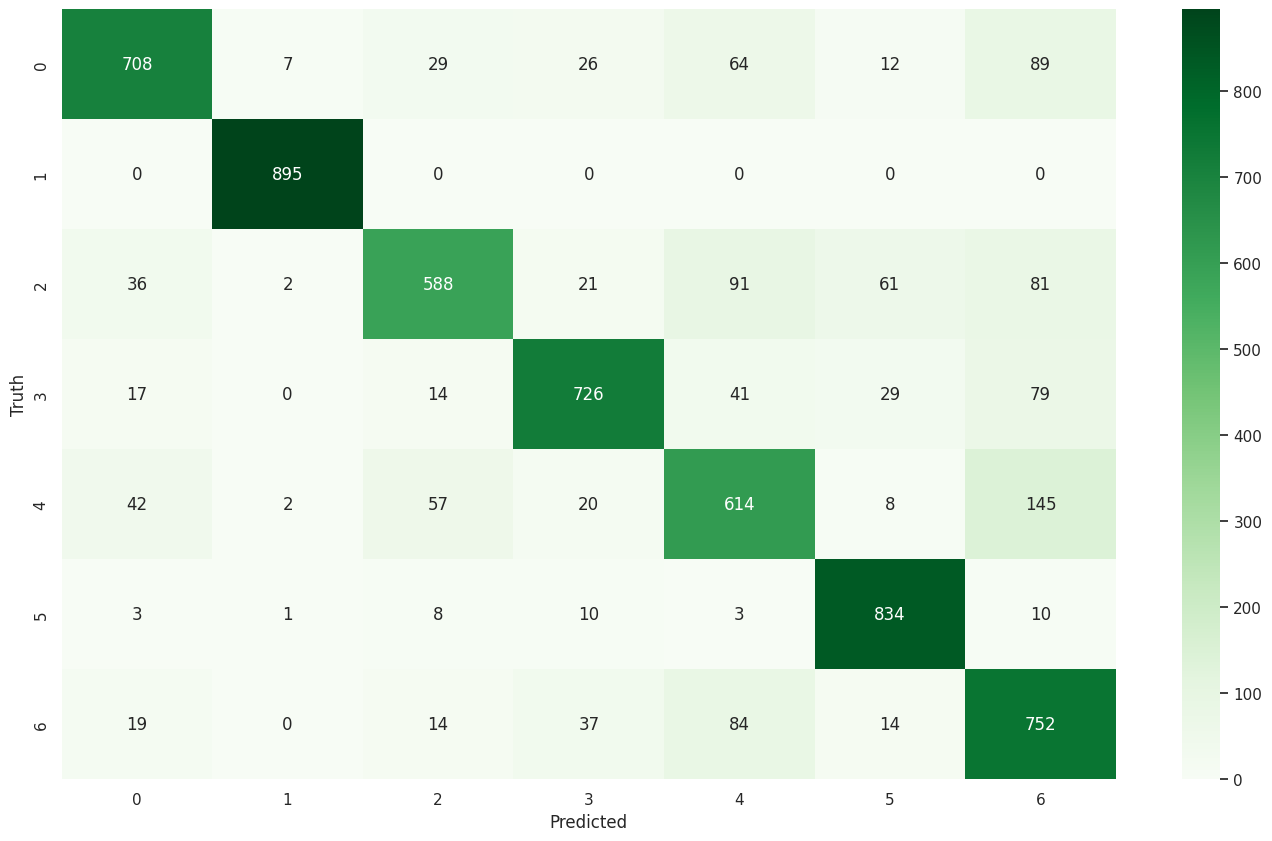

In [32]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (17, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Truth')

## **8. Save the Model**

In [33]:
# Save the Model
model.save("/content/drive/MyDrive/Thesis Work - Facial Expression Detection & Recognition using Deep Learning/Facial_Expression_Detection_System.hdf5")

In [42]:
#Saving the  model to  use it later on
fer_json = model.to_json()
with open("/content/drive/MyDrive/Thesis Work - Facial Expression Detection & Recognition using Deep Learning/Facial Expression Recognition.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

## **9. Making Prediction in a Real-Time**

In [ ]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

#load model
model = model_from_json(open("/content/drive/MyDrive/Thesis Work - Facial Expression Detection & Recognition using Deep Learning/Facial Expression Recognition.json", "r").read())
#load weights
model.load_weights('fer.h5')

face_haar_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Thesis Work - Facial Expression Detection & Recognition using Deep Learning/haarcascade_frontalface_default.xml')

cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows